# Sandbox for CLTV analysis

In [2]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.geom import Geometric, neg_loglikelihood
from jax_cltv.plots.plot_data import plot_churns, plot_survives

plt.style.use('bmh')

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [4]:
theta_true = 0.2

ds, data = DummySubscriptions(p=.2, size=1000)()

In [5]:
data.shape

(1000, 29)

In [6]:
df = ds.to_pandas()

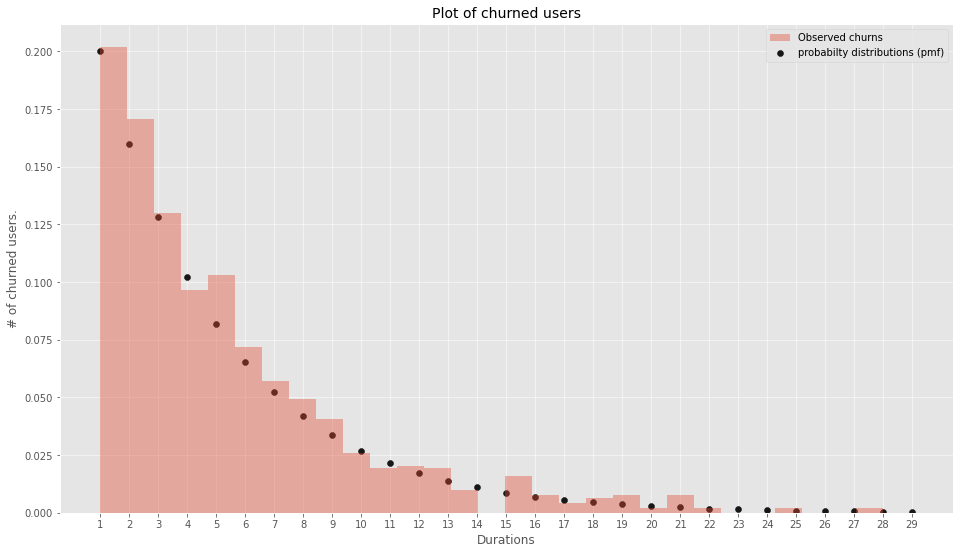

In [7]:
ax = plot_churns(df, theta=.2, kind='hist', density=True)
plt.show()

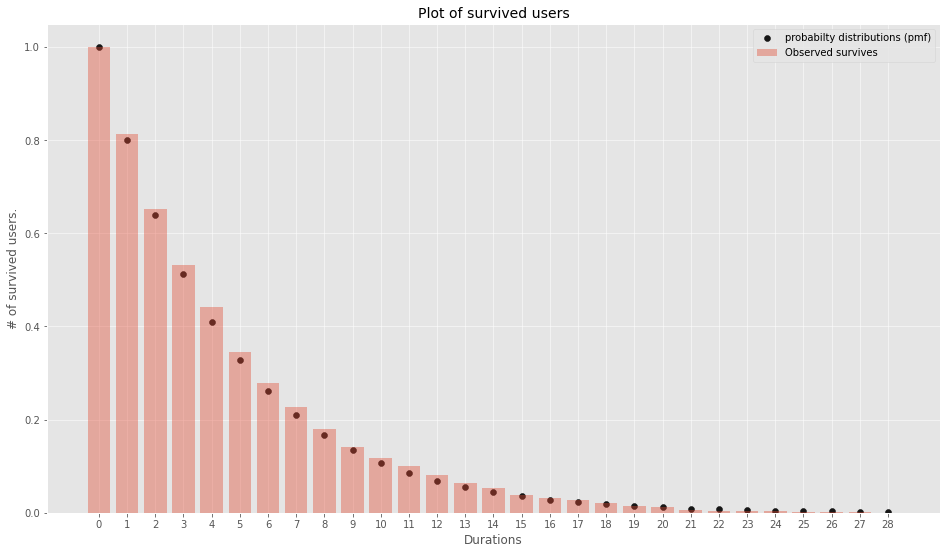

In [8]:
ax = plot_survives(df, theta=.2, density=True)
plt.show()

## Inference with MLE

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)

In [11]:
y_train = df_train.sum(axis=1).astype('int')
y_test = df_test.sum(axis=1).astype('int')

In [12]:
print(f'Training data: {y_train.shape}')
print(f'Test data: {y_test.shape}')

Training data: (700,)
Test data: (300,)


In [13]:
def model():
    return MLE(dist=Geometric(0.8))

def loss(w, x, y):
    nl, _ = neg_loglikelihood(x, w[0])
    return nl

In [25]:
init_variables(['m', 'res'])

m = model()
w_init = jnp.array(list(m.params.values()))
res = m.fit(loss, w_init, (jnp.array(y_train), None))

In [15]:
res.params

DeviceArray([0.19644034], dtype=float32)

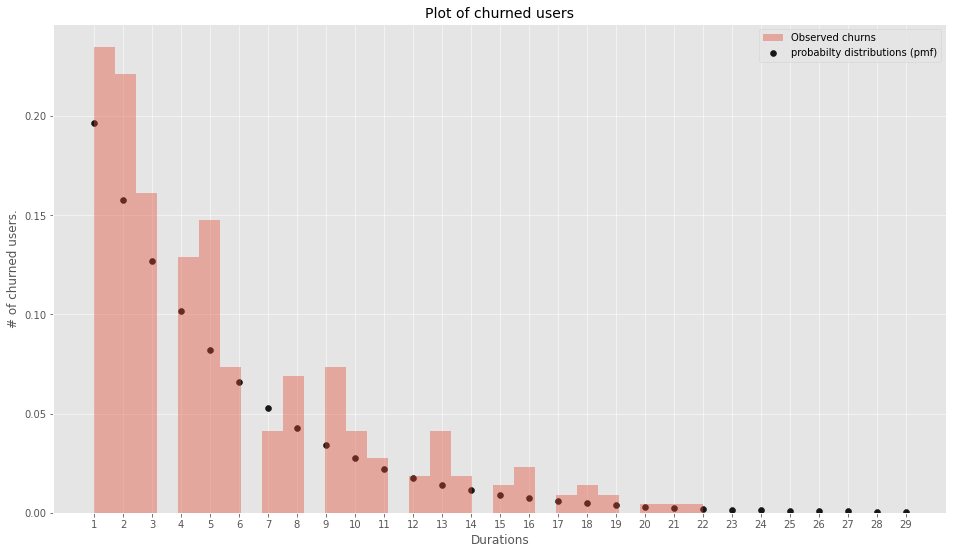

In [16]:
ax = plot_churns(df_test, theta=res.params, kind='hist', density=True)
plt.show()

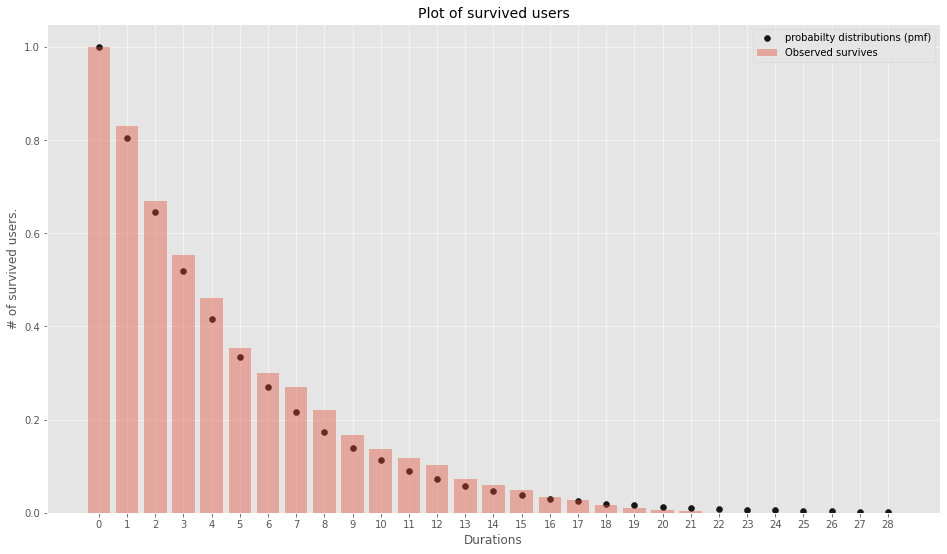

In [17]:
ax = plot_survives(df_test, theta=res.params, density=True)
plt.show()

In [18]:
from jax.scipy.stats import geom

In [31]:
M = 100
d = 0.15

In [20]:
def calc_revenues(row, df, key, m, d):
    idx = df[df[key]==row].index[0]
    return  (m/(1 + d)**idx) * row


def calc_cltv(theta, d, m, T):
    N, D = df.shape
    dcf = []
    s = []

    def churn(theta, t):
        return (1-theta)**(t-1) * theta

    def survive(theta, t):
        return (1-theta)**t

    for t in range(T+1):
        s.append(survive(theta, t))
        dcf.append((1/(1+d)**t))
        # if t == 0:
        #     s.append(1)
        #     dcf.append(1)
        # else:
        #     s.append(survive(theta, t))
        #     dcf.append((1/(1+d)**t))

    clv = m * np.sum([x * y for x, y in zip(s, dcf)])
    return clv

In [21]:
def get_df_cltv(df, m, d, theta):
    N, D = df.shape
    df_cltv = pd.concat([
        pd.DataFrame({'observed_churns': df.sum(axis=1).value_counts()}),
        pd.DataFrame({'pmf_churn_rate': geom.pmf(jnp.array(range(D)), theta)})
    ], axis=1)
    df_cltv.fillna(0, inplace=True)
    df_cltv['observed_survives'] = N - df_cltv['observed_churns'].cumsum()
    df_cltv['ob_churn_rate'] = df_cltv['observed_churns'] / N
    df_cltv['ob_survive_rate'] = df_cltv['observed_survives'] / N
    df_cltv['pmf_survive_rate'] = 1 - df_cltv['pmf_churn_rate'].cumsum()
    df_cltv['day'] = df_cltv.index.map(lambda x: f'Day{int(x)}')
    df_cltv['ob_monetization'] = df_cltv['ob_survive_rate'].map(
        lambda x: calc_revenues(x, df_cltv, 'ob_survive_rate', m, d))
    df_cltv['ob_cltv'] = df_cltv['ob_monetization'].cumsum()

    return df_cltv

In [32]:
df_cltv = get_df_cltv(df_test, M, d, res.params)
df_cltv['modeled_cltv'] = df_cltv.index.map(
    lambda r: calc_cltv(res.params, d, M, int(r)))

In [33]:
df_cltv

,observed_churns,pmf_churn_rate,observed_survives,ob_churn_rate,ob_survive_rate,pmf_survive_rate,day,ob_monetization,ob_cltv,modeled_cltv
0.0,0.0,0.000000,300.0,0.000000,1.000000,1.000000,Day0,100.000000,100.000000,100.000000
1.0,51.0,0.196440,249.0,0.170000,0.830000,0.803560,Day1,72.173913,172.173913,169.874752
2.0,48.0,0.157852,201.0,0.160000,0.670000,0.645708,Day2,50.661626,222.835539,218.699574
3.0,35.0,0.126843,166.0,0.116667,0.553333,0.518865,Day3,36.382565,259.218104,252.815795
4.0,28.0,0.101926,138.0,0.093333,0.460000,0.416939,Day4,26.300649,285.518753,276.654410
5.0,32.0,0.081904,106.0,0.106667,0.353333,0.335035,Day5,17.566911,303.085664,293.311596
6.0,16.0,0.065814,90.0,0.053333,0.300000,0.269221,Day6,12.969828,316.055492,304.950762
7.0,9.0,0.052886,81.0,0.030000,0.270000,0.216335,Day7,10.150300,326.205792,313.083577
8.0,15.0,0.042497,66.0,0.050000,0.220000,0.173838,Day8,7.191839,333.397631,318.766379
9.0,16.0,0.034149,50.0,0.053333,0.166667,0.139689,Day9,4.737707,338.135338,322.737217


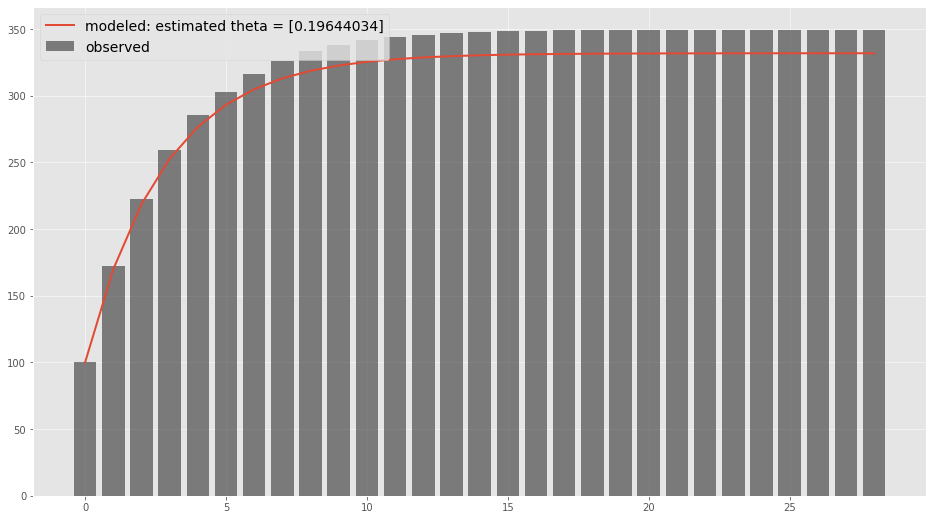

In [34]:
fig = plt.figure(figsize=(16, 9))
plt.bar(df_cltv.index, df_cltv['ob_cltv'], label='observed', color='#333333', alpha=.6)
plt.plot(df_cltv.index, df_cltv['modeled_cltv'], label=f'modeled: estimated theta = {res.params}')
plt.legend(fontsize=14)
plt.show()

In [35]:
print(f'Average retentions based on the true parameter: {1/theta_true}')
print(f'Average retentions based on the training data: {df_train.sum(axis=1).mean()}')
print(f'Average retentions based on the test data: {df_test.sum(axis=1).mean()}')
print(f'Average retentions based on an inferenced parameter: {1/res.params.to_py()}')

Average retentions based on the true parameter: 5.0
Average retentions based on the training data: 5.09
Average retentions based on the test data: 5.46
Average retentions based on an inferenced parameter: [5.0906043]


## CLTV modeling with poisson noise

Now we're going to see how the MLE modeling works when training data has poisson noise.
The retentions are sampled from a geeometric and a poisson distributions as follows:  

$$
t_i \sim \mathcal{Geom} (\theta) + \mathcal{Poi} (\lambda) \\
where \theta = 0.2 \space\space and \space\space \lambda = 0.5 \\
$$

In [50]:
ds, data = DummySubscriptions(p=theta_true, size=1000, noise={'lam': 1.0})()
df = ds.to_pandas()

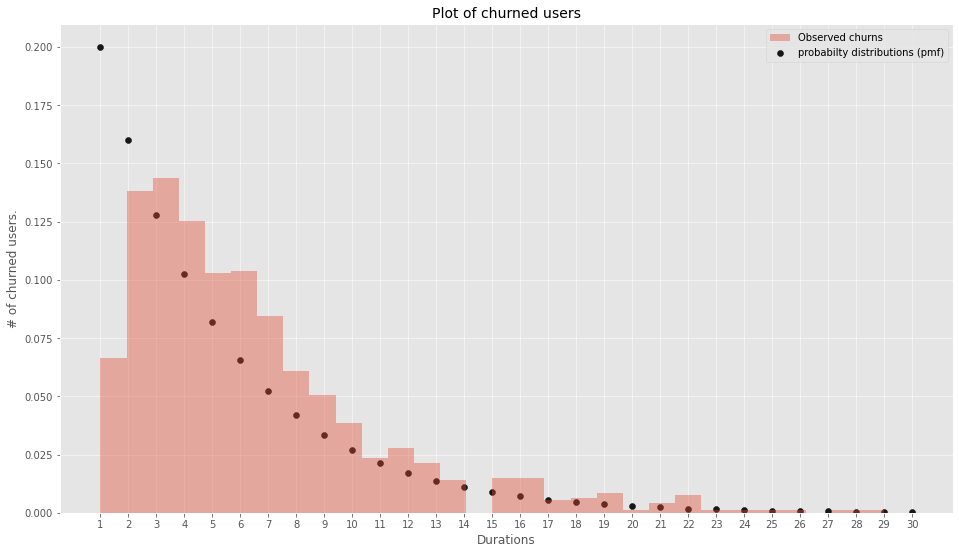

In [51]:
ax = plot_churns(df, theta=.2, kind='hist', density=True)
plt.show()

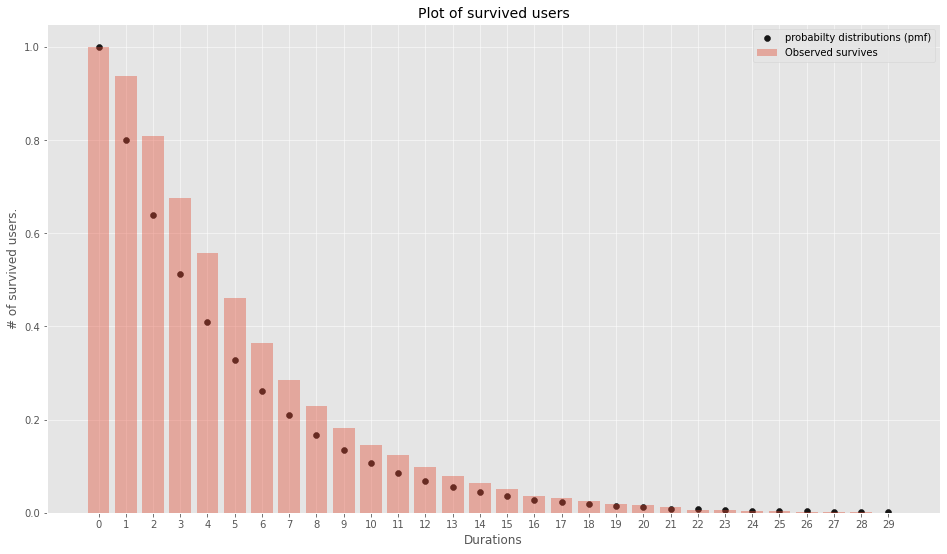

In [52]:
ax = plot_survives(df, theta=.2, density=True)
plt.show()

In [53]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)
y_train = df_train.sum(axis=1).astype('int')
y_test = df_test.sum(axis=1).astype('int')

In [54]:
init_variables(['m', 'res'])

m = model()
w_init = jnp.array(list(m.params.values()))
res = m.fit(loss, w_init, (jnp.array(y_train), None))

In [55]:
res.params

DeviceArray([0.16382219], dtype=float32)

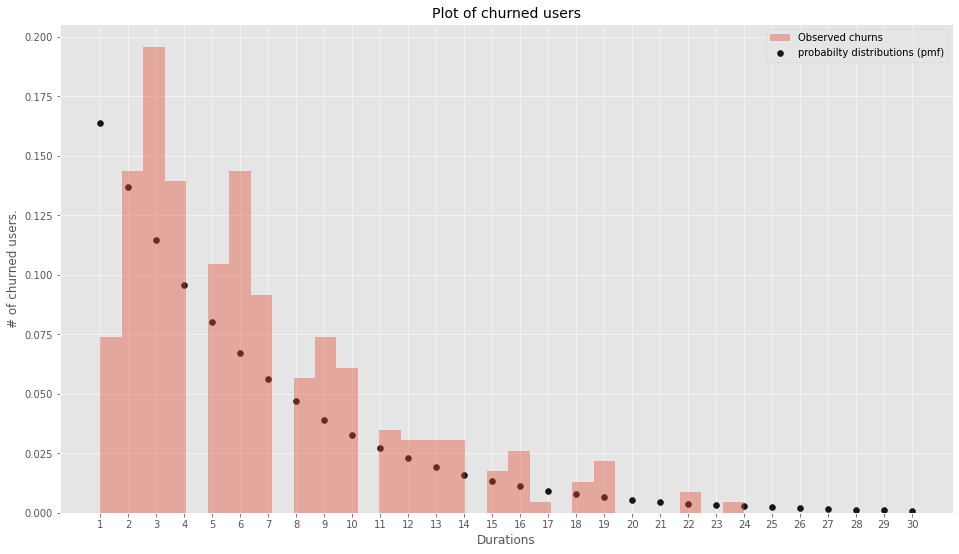

In [56]:
ax = plot_churns(df_test, theta=res.params, kind='hist', density=True)
plt.show()

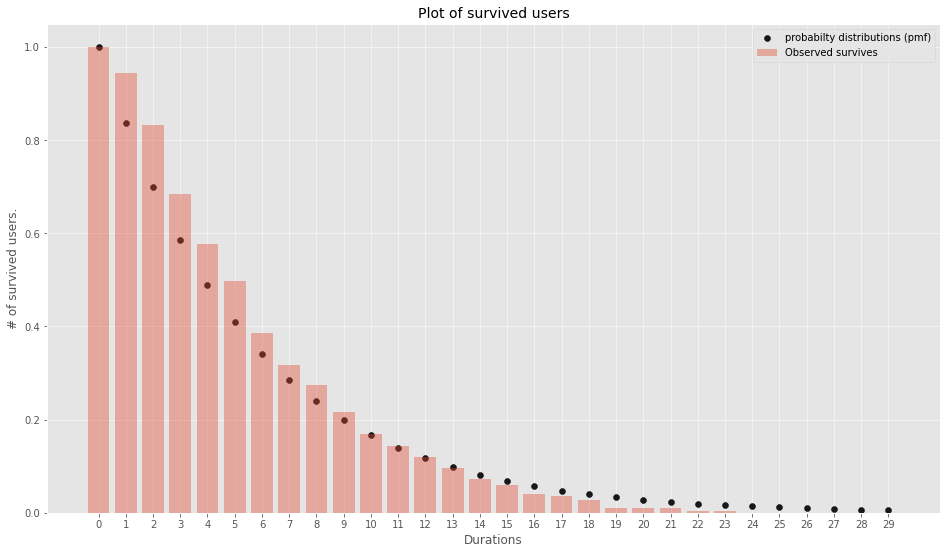

In [57]:
ax = plot_survives(df_test, theta=res.params, density=True)
plt.show()

In [58]:
df_test

,Day0,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,...,Day20,Day21,Day22,Day23,Day24,Day25,Day26,Day27,Day28,Day29
507,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
818,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
M = 100
d = 0.15

In [60]:
df_cltv = get_df_cltv(df_test, M, d, res.params)
df_cltv['modeled_cltv'] = df_cltv.index.map(
    lambda r: calc_cltv(res.params, d, M, int(r)))

In [61]:
df_cltv

,observed_churns,pmf_churn_rate,observed_survives,ob_churn_rate,ob_survive_rate,pmf_survive_rate,day,ob_monetization,ob_cltv,modeled_cltv
0.0,0.0,0.000000,300.0,0.000000,1.000000,1.000000,Day0,100.000000,100.000000,100.000000
1.0,17.0,0.163822,283.0,0.056667,0.943333,0.836178,Day1,82.028986,182.028986,172.711110
2.0,33.0,0.136984,250.0,0.110000,0.833333,0.699193,Day2,63.011972,245.040958,225.580168
3.0,45.0,0.114543,205.0,0.150000,0.683333,0.584650,Day3,44.930276,289.971234,264.021850
4.0,32.0,0.095779,173.0,0.106667,0.576667,0.488871,Day4,32.971104,322.942337,291.973233
5.0,24.0,0.080088,149.0,0.080000,0.496667,0.408783,Day5,24.693111,347.635449,312.296987
6.0,33.0,0.066968,116.0,0.110000,0.386667,0.341816,Day6,16.716667,364.352116,327.074623
7.0,21.0,0.055997,95.0,0.070000,0.316667,0.285819,Day7,11.904673,376.256789,337.819624
8.0,13.0,0.046823,82.0,0.043333,0.273333,0.238995,Day8,8.935315,385.192104,345.632410
9.0,17.0,0.039153,65.0,0.056667,0.216667,0.199842,Day9,6.159019,391.351123,351.313186


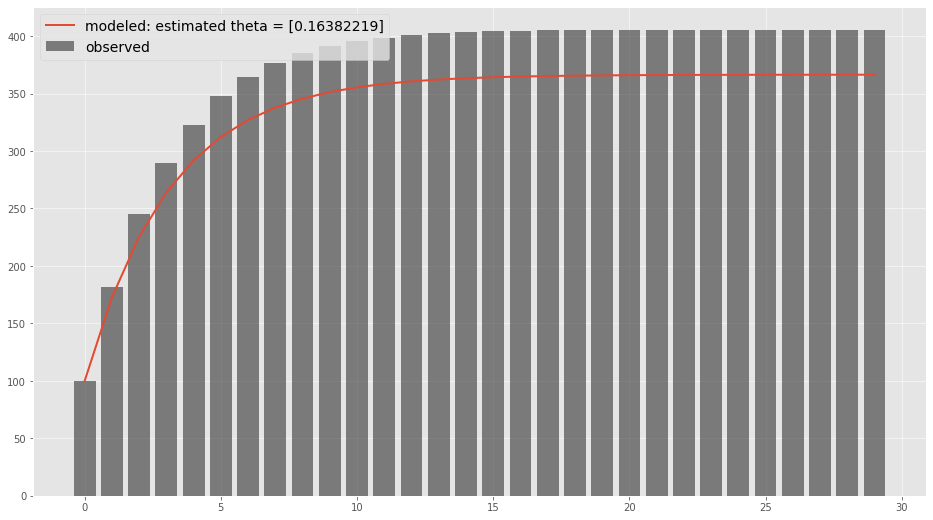

In [62]:
fig = plt.figure(figsize=(16, 9))
plt.bar(df_cltv.index, df_cltv['ob_cltv'], label='observed', color='#333333', alpha=.6)
plt.plot(df_cltv.index, df_cltv['modeled_cltv'], label=f'modeled: estimated theta = {res.params}')
plt.legend(fontsize=14)
plt.show()

In [63]:
print(f'Average retentions based on the true parameter: {1/theta_true}')
print(f'Average retentions based on the training data: {df_train.sum(axis=1).mean()}')
print(f'Average retentions based on the test data: {df_test.sum(axis=1).mean()}')
print(f'Average retentions based on an inferenced parameter: {1/res.params.to_py()}')

Average retentions based on the true parameter: 5.0
Average retentions based on the training data: 6.104285714285714
Average retentions based on the test data: 6.53
Average retentions based on an inferenced parameter: [6.1041794]
